In [10]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
plt.rcParams['figure.figsize'] = (30,30)

In [28]:
df = pd.read_csv('../data/df.csv')

/Users/Vittorio/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47,48,49,50,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df

,Unnamed: 0,matchID,date,day_of_week,name,league,game_number,score,length_outs,day_night,park_id,attendance,length_minutes,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional walks,...,errors,passed_balls,double_plays,triple_plays,hp_umpire_id,1b_umpire_id,2b_umpire_id,3b_umpire_id,manager_id,winning_pitcher_id,losing_pitcher_id,saving_pitcher_id,winning_rbi_batter_id,starting_pitcher_id,player_1_id,player_2_id,player_3_id,player_4_id,player_5_id,player_6_id,player_7_id,player_8_id,player_9_id,winning_team,winner
0,55,62,18710707,Fri,CH1,na,14,7,54.0,D,CHI01,5000.0,100.0,010040200,37.0,8.0,3.0,1.0,1.0,6.0,0.0,0.0,0.0,2.0,-1.0,...,4.0,0.0,0.0,0.0,hasts101,NaN,NaN,NaN,woodj106,zettg101,spala101,NaN,NaN,zettg101,duffe101,woodj106,treaf101,kingm101,mcatb101,simmj101,pinke101,hodec101,zettg101,Home,1.0
1,145,153,18720511,Sat,BL1,na,10,8,54.0,D,BAL02,20349.0,115.0,140000030,41.0,11.0,3.0,1.0,1.0,4.0,0.0,0.0,0.0,1.0,-1.0,...,4.0,0.0,0.0,0.0,bomet901,NaN,NaN,NaN,cravb101,mathb101,zettg101,NaN,NaN,mathb101,radcj101,cravb101,pikel101,fishc102,yorkt101,highd101,mille105,hallg101,mathb101,Home,1.0
2,182,191,18720615,Sat,PH1,na,12,11,54.0,D,PHI01,600.0,95.0,200042021,44.0,14.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,-1.0,...,5.0,0.0,1.0,0.0,mcleb901,NaN,NaN,NaN,mcbrd101,mcbrd101,britj103,NaN,NaN,mcbrd101,cuthn101,mcbrd101,meyel102,malof101,fislw101,treaf101,ansoc101,mcgem101,mackd101,Home,1.0
3,195,204,18720626,Wed,BL1,na,24,9,54.0,D,BAL02,20349.0,110.0,302000103,48.0,9.0,-1.0,-1.0,-1.0,5.0,0.0,0.0,0.0,0.0,-1.0,...,4.0,-1.0,-1.0,0.0,younn801,NaN,NaN,NaN,cravb101,mathb101,steab101,NaN,NaN,mathb101,radcj101,highd101,pikel101,yorkt101,fishc102,caret101,mille105,hallg101,mathb101,Home,1.0
4,204,213,18720704,Thu,NY2,na,23,20,54.0,D,NYC01,3000.0,140.0,40020(11)210,55.0,23.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,1.0,-1.0,...,3.0,0.0,0.0,0.0,kennj102,NaN,NaN,NaN,hatfj101,cummc101,woltr101,NaN,NaN,cummc101,eggld101,hatfj101,starj101,bechg101,hickn101,boydb101,mcmuj101,fulmc102,cummc101,Home,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281773,140883,171901,20161002,Sun,CIN,NL,162,4,54.0,D,CIN09,32587.0,198.0,300100000,32.0,6.0,2.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,1.0,0.0,whitc901,belld901,morag901,hallt901,pricb801,grimj002,igler001,edwac001,szczm001,stepr002,peraj003,dejei002,vottj001,duvaa001,sches001,suare001,barnt001,rendt001,stepr002,Visitor,0.0
281774,140884,171902,20161002,Sun,COL,NL,162,4,60.0,D,DEN02,27762.0,203.0,1100100010,41.0,13.0,4.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,barrs901,woodt901,randt901,ortir901,weisw001,thort001,rusic001,knebc001,susaa001,marqg001,blacc001,dahld001,arenn001,gonzc001,murpt002,pattj005,valap001,adamc001,marqg001,Visitor,0.0
281775,140885,171903,20161002,Sun,PHI,NL,162,5,51.0,D,PHI13,36935.0,159.0,00100031x,33.0,10.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,barkl901,herna901,barrt901,littw901,mackp101,murrc002,goede001,nerih001,hernc005,eickj001,hernc005,parej002,herro001,franm004,howar001,ruppc001,blana001,altha001,eickj001,Visitor,0.0
281776,140887,171905,20161002,Sun,SLN,NL,162,10,51.0,D,STL10,44615.0,192.0,00100360x,36.0,12.0,2.0,0.0,1.0,10.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,1.0,0.0,cuzzp901,ticht901,vanol901,marqa901,mathm001,broxj001,nicaj001,NaN,piscs001,waina001,carpm002,diaza003,moliy001,piscs001,peraj001,mossb001,gyorj001,gricr001,waina001,Visitor,0.0


In [30]:
for column in df.columns:
    if '_id' in column:
        df.drop(columns=column, inplace=True)

In [40]:
df = df.fillna(0)

In [41]:
# feature selection
y = df['winner']
X = df.drop(columns=['Unnamed: 0', 'matchID', 'winner', 'league', 'score', 'winning_team', 'line_score', 'name', 'day_night'])

In [42]:
# Preparing the data for the VIF analysis
day = X['day_of_week'].str.get_dummies()
X = X.join(day)
X.drop(columns=['day_of_week'], inplace=True)

In [43]:
Xvif = X.loc[:, :'triple_plays']

In [44]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]
# list(zip(Xvif.columns, vif))

[('date', 54.40320678614226),
 ('game_number', 3.7498209682226062),
 ('length_outs', 4725.428185848392),
 ('attendance', 5.4793624780742745),
 ('length_minutes', 54.04781755002053),
 ('at_bats', 1910.5510770947842),
 ('hits', 67.55878523085794),
 ('doubles', 3.3700460196758493),
 ('triples', 1.4290143410028318),
 ('homeruns', 2.560461324352677),
 ('rbi', 37.24443457275689),
 ('sacrifice_hits', 3.1411217334683106),
 ('sacrifice_flies', 1.6029046651579981),
 ('hit_by_pitch', 1.6721943605155387),
 ('walks', 22.827572679913644),
 ('intentional walks', 1.7128310535060192),
 ('strikeouts', 5.702548297822427),
 ('stolen_bases', 1.5496205980119004),
 ('caught_stealing', 1.3646391214130396),
 ('grounded_into_double', 2.108524683667799),
 ('first_catcher_interference', 1.3840191532160546),
 ('left_on_base', 85.57063043359338),
 ('pitchers_used', 9.244441076577745),
 ('individual_earned_runs', 13.424128491871077),
 ('team_earned_runs', 11.81479571476836),
 ('wild_pitches', 1.2902120652804872),
 (

In [45]:
y = df['winner']
# Columns dropped after VIF analysis:
X.drop(columns=['length_outs', 'at_bats', 'putouts'], inplace=True)

In [46]:
# Decision tree to identify important features
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
                                                   )

X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                           y_train,
                                                           test_size=0.3,
                                                           random_state=42
                                                           )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

In [47]:
# Train Decision tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

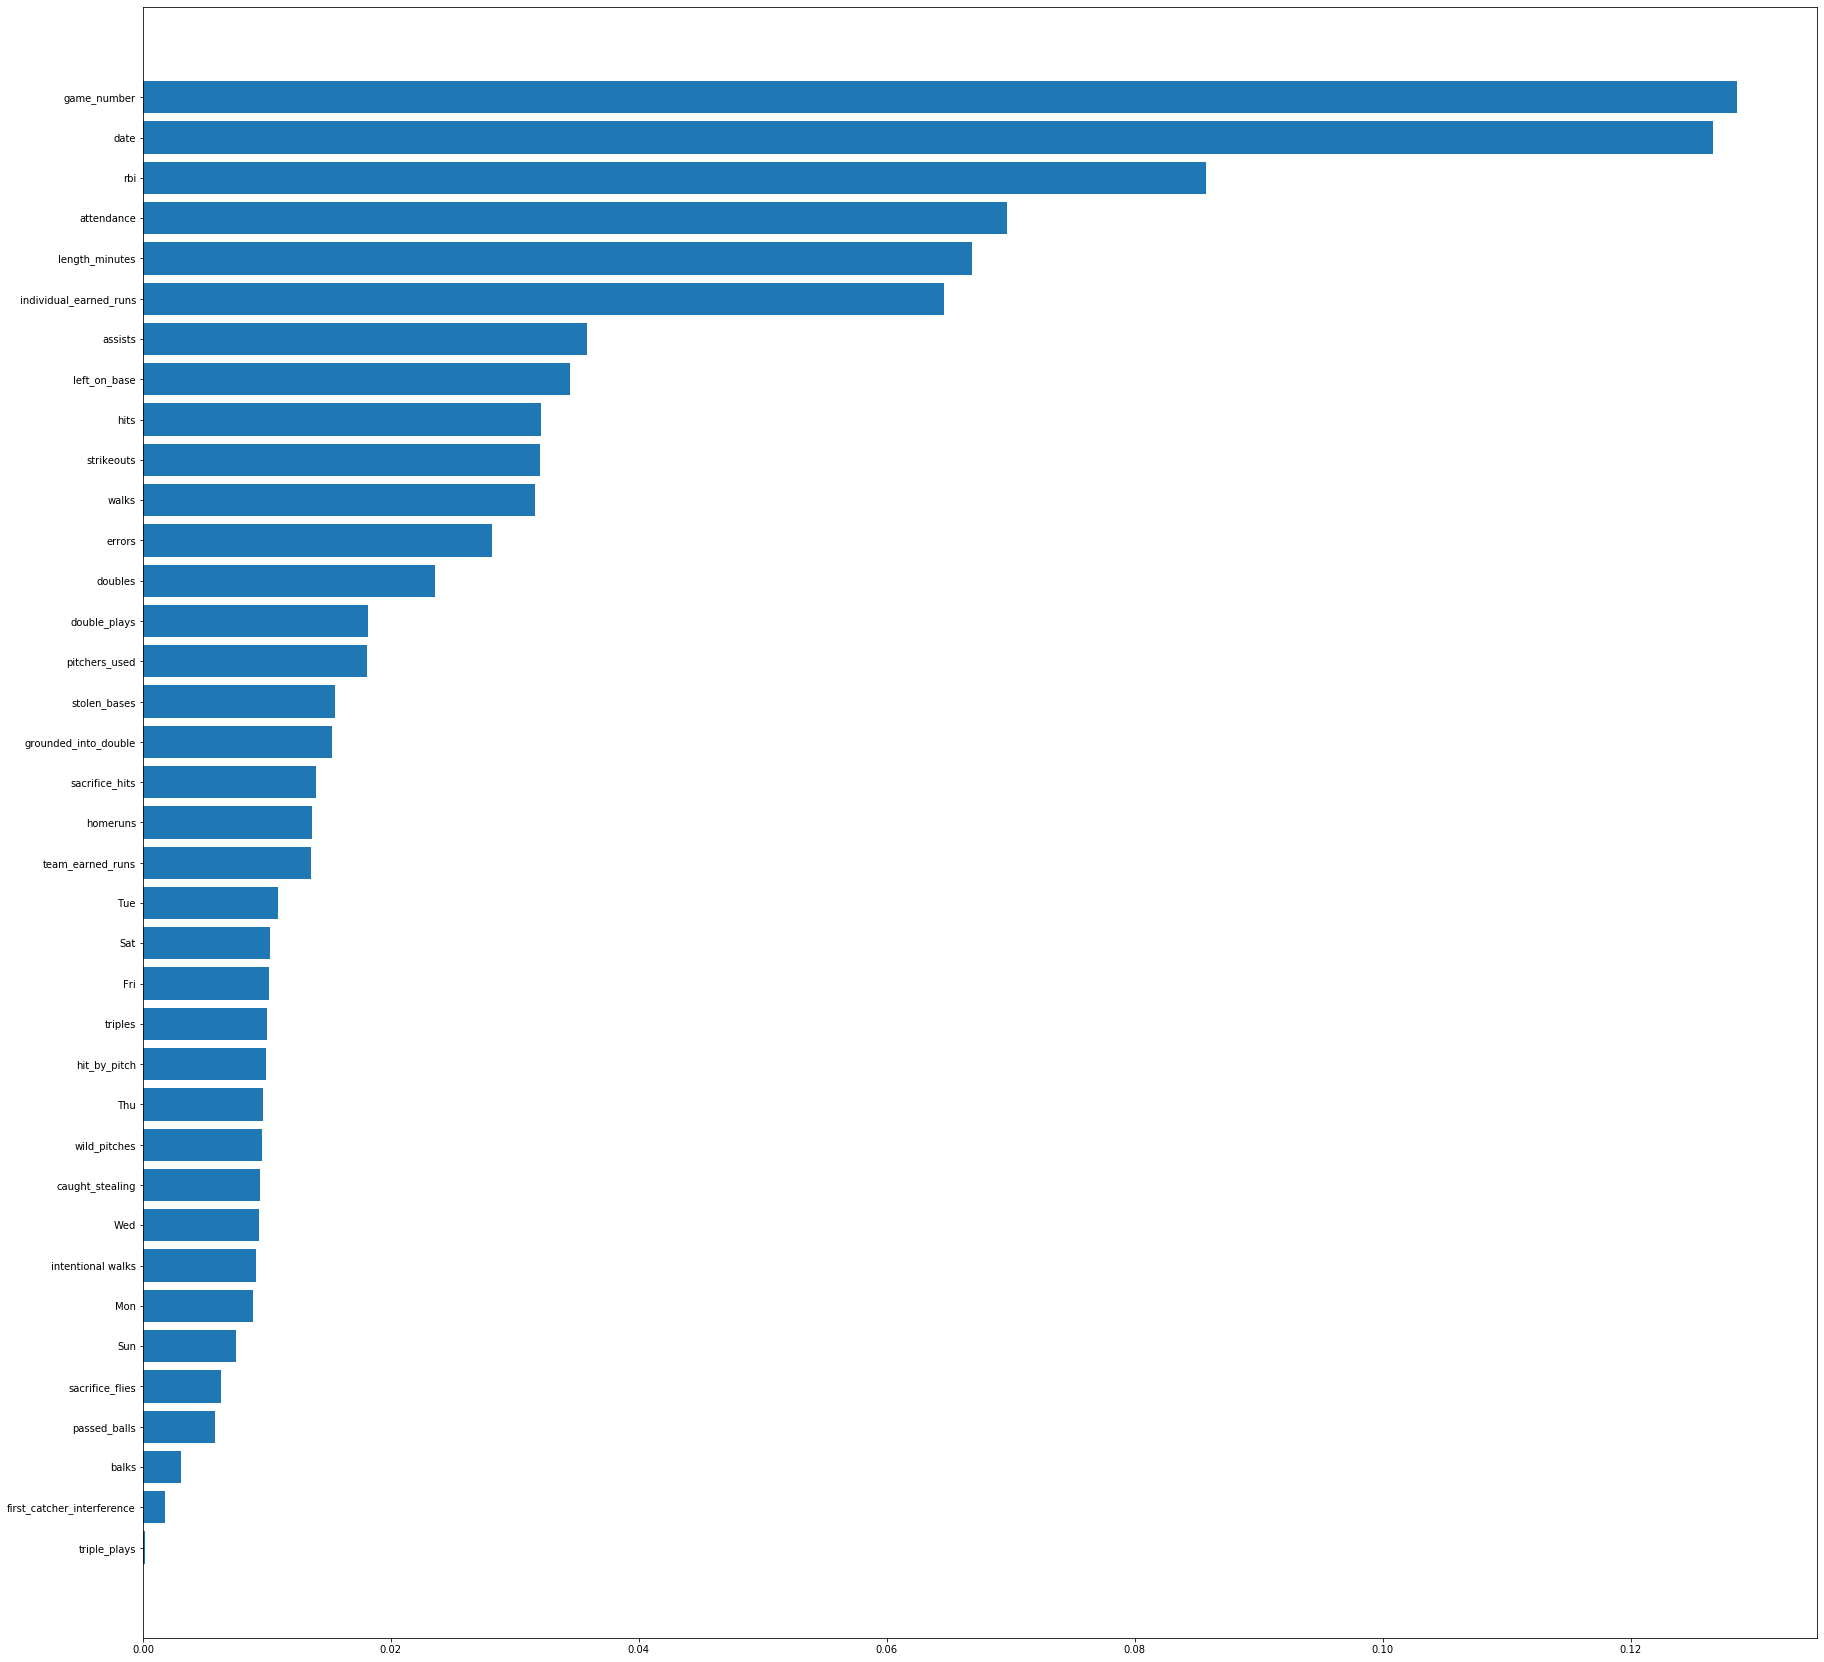

In [48]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)),importances[indices], align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);

In [49]:
# logistic regression as baseline model
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_validate_s = scaler.transform(X_validate)

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_s, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [50]:
# ROC_AUC of the folds
cross_val_score(logreg, X_train_s, y_train, scoring='roc_auc', cv=kfold)

array([0.59252671, 0.59919449, 0.59291932, 0.59899295, 0.59309701])

In [51]:
# AUC score of train vs validate
y_score = logreg.fit(X_train_s, y_train).decision_function(X_validate_s)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.5942847890087066
